Step 1: Define the Problem

Step 2: Gather the Data

Step 3: Prepare Data for Consumption

In [1]:
##ライブラリのインポート
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import sklearn

#misc libraries
import random
import time

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
##データの確認
data_raw = pd.read_csv('Titanic.train.csv')
data_val = pd.read_csv('Titanic.test.csv')
data1 = data_raw.copy(deep = True) #deepで元のdfを変更しても反映されない

#however passing by reference is convenient, because we can clean both datasets at once
data_cleaner = [data1, data_val]

data_raw.info()
data_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
##欠損値の処理
data1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
data_val.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
#complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

In [7]:
#特徴量追加：家族サイズ
#Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #Continuous variable bins; qcut vs cut
    #Fare Bins/Buckets using qcut or frequency bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


    
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)


#preview data again
data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
81,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,9.5000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
100,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,7.8958,S,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"
389,1,2,"Lehmann, Miss. Bertha",female,17.0,0,0,12.0000,C,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
231,0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,7.7750,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
787,0,3,"Rice, Master. George Hugh",male,8.0,4,1,29.1250,Q,6,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
641,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,69.3000,C,1,1,Misc,"(31.0, 512.329]","(16.0, 32.0]"
290,1,1,"Barber, Miss. Ellen ""Nellie""",female,26.0,0,0,78.8500,S,1,1,Miss,"(31.0, 512.329]","(16.0, 32.0]"
584,0,3,"Paulner, Mr. Uscher",male,28.0,0,0,8.7125,C,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
419,0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,24.1500,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
684,0,2,"Brown, Mr. Thomas William Solomon",male,60.0,1,1,39.0000,S,3,0,Mr,"(31.0, 512.329]","(48.0, 64.0]"


In [8]:
#ダミー変数
#convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [9]:
#欠損値確認アゲイン
data1.isnull().sum()

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64

In [10]:
data_val.isnull().sum()

PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            327
Embarked           0
FamilySize         0
IsAlone            0
Title              0
FareBin            0
AgeBin             0
Sex_Code           0
Embarked_Code      0
Title_Code         0
AgeBin_Code        0
FareBin_Code       0
dtype: int64

In [11]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

train1_x_bin.head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


Step 4: Perform Exploratory Analysis with Statistics¶

In [12]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

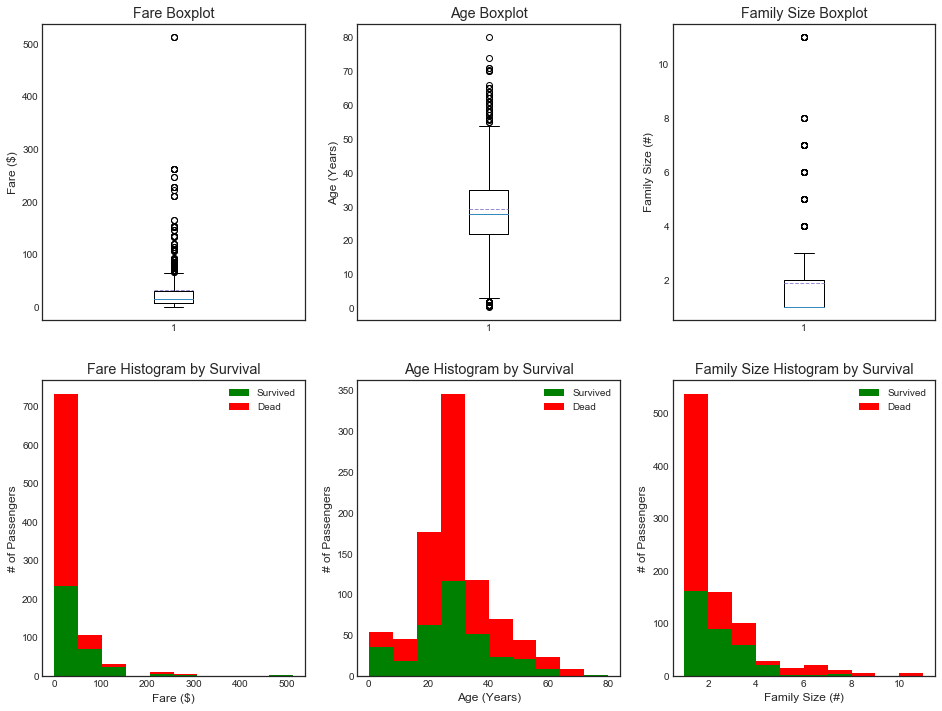

In [13]:
##可視化
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas

#we will use matplotlib.pyplot

#to organize our graphics will use figure, subplot, and subplotS
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

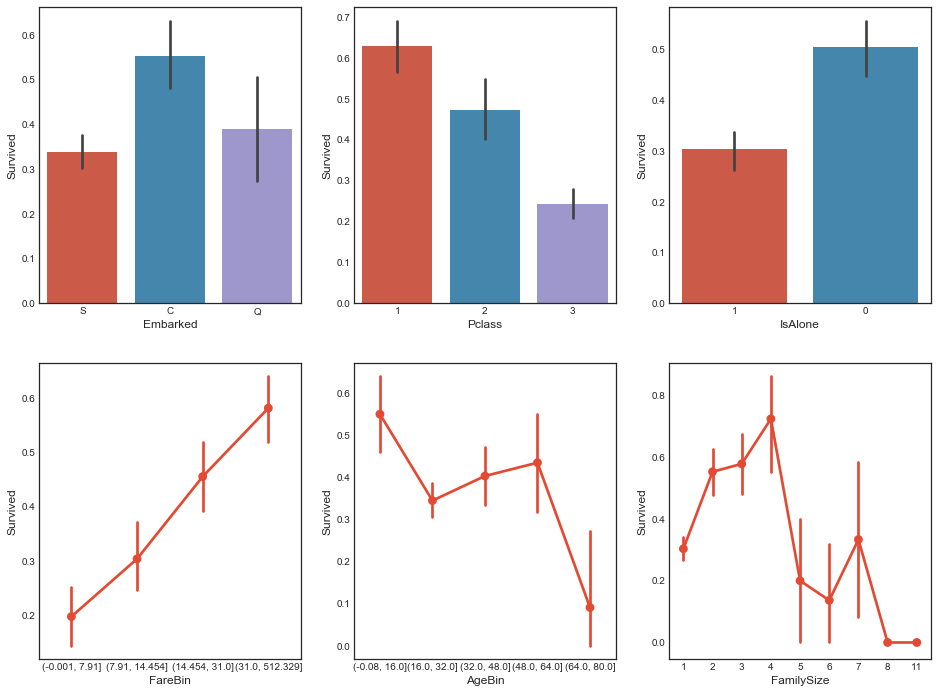

In [14]:
#we will use seaborn graphics for multi-variable comparison: https://seaborn.pydata.org/api.html

#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

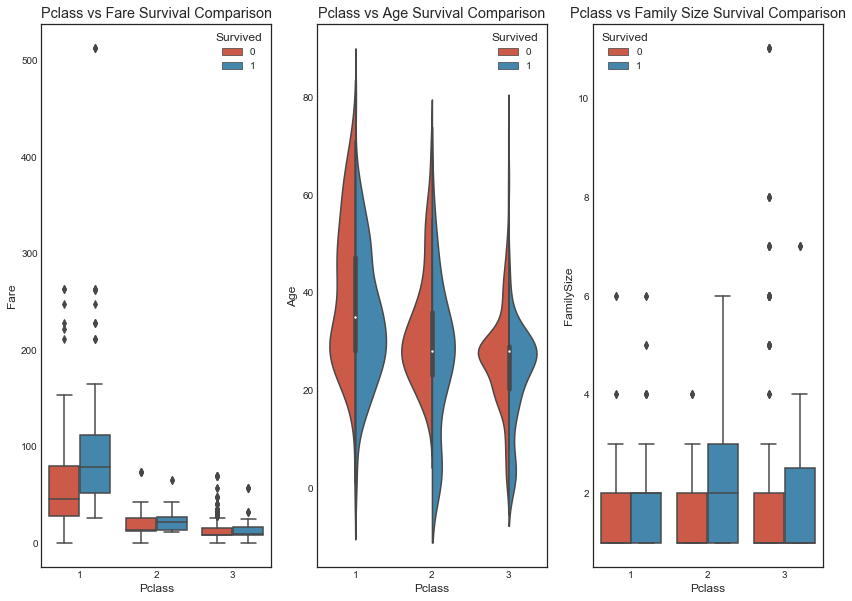

In [15]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,10))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5,1,'Sex vs IsAlone Survival Comparison')

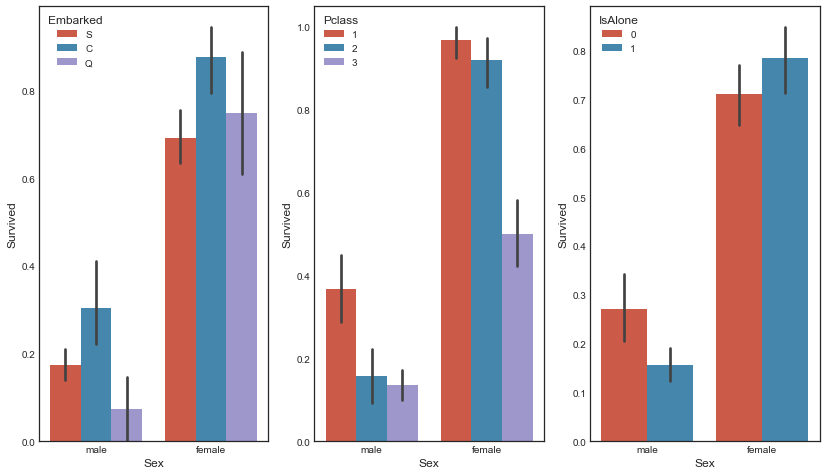

In [16]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
fig, qaxis = plt.subplots(1,3,figsize=(14,8))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

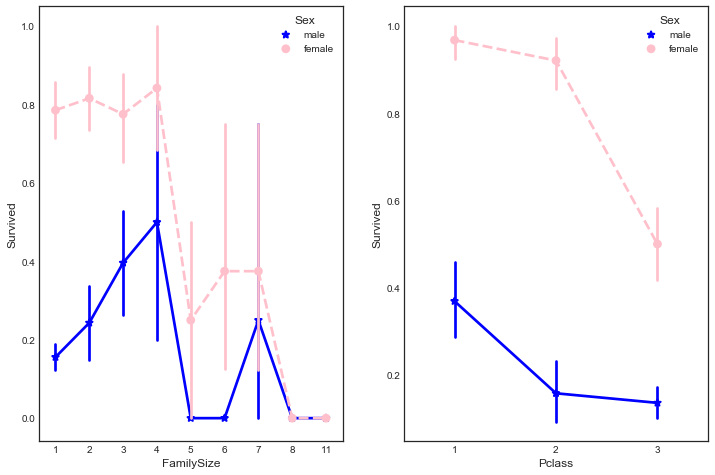

In [17]:
#more side-by-side comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(12,8))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

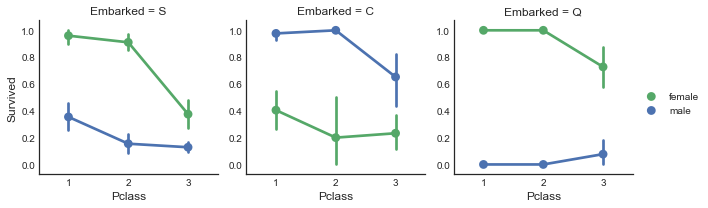

In [18]:
#how does embark port factor with class, sex, and survival compare
#facetgrid: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

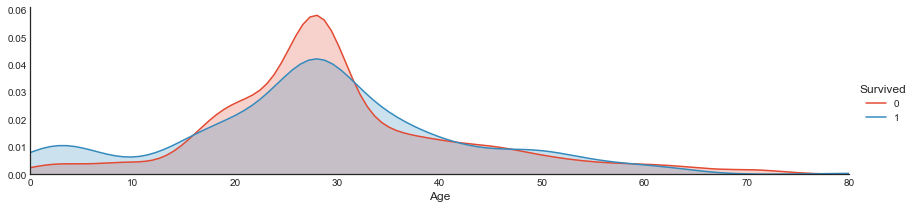

In [19]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

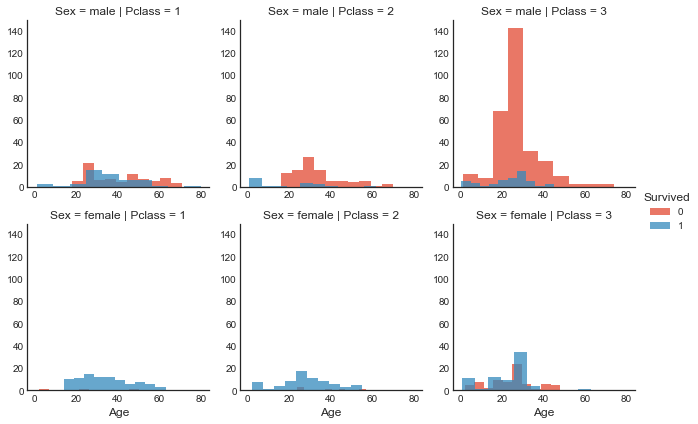

In [20]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

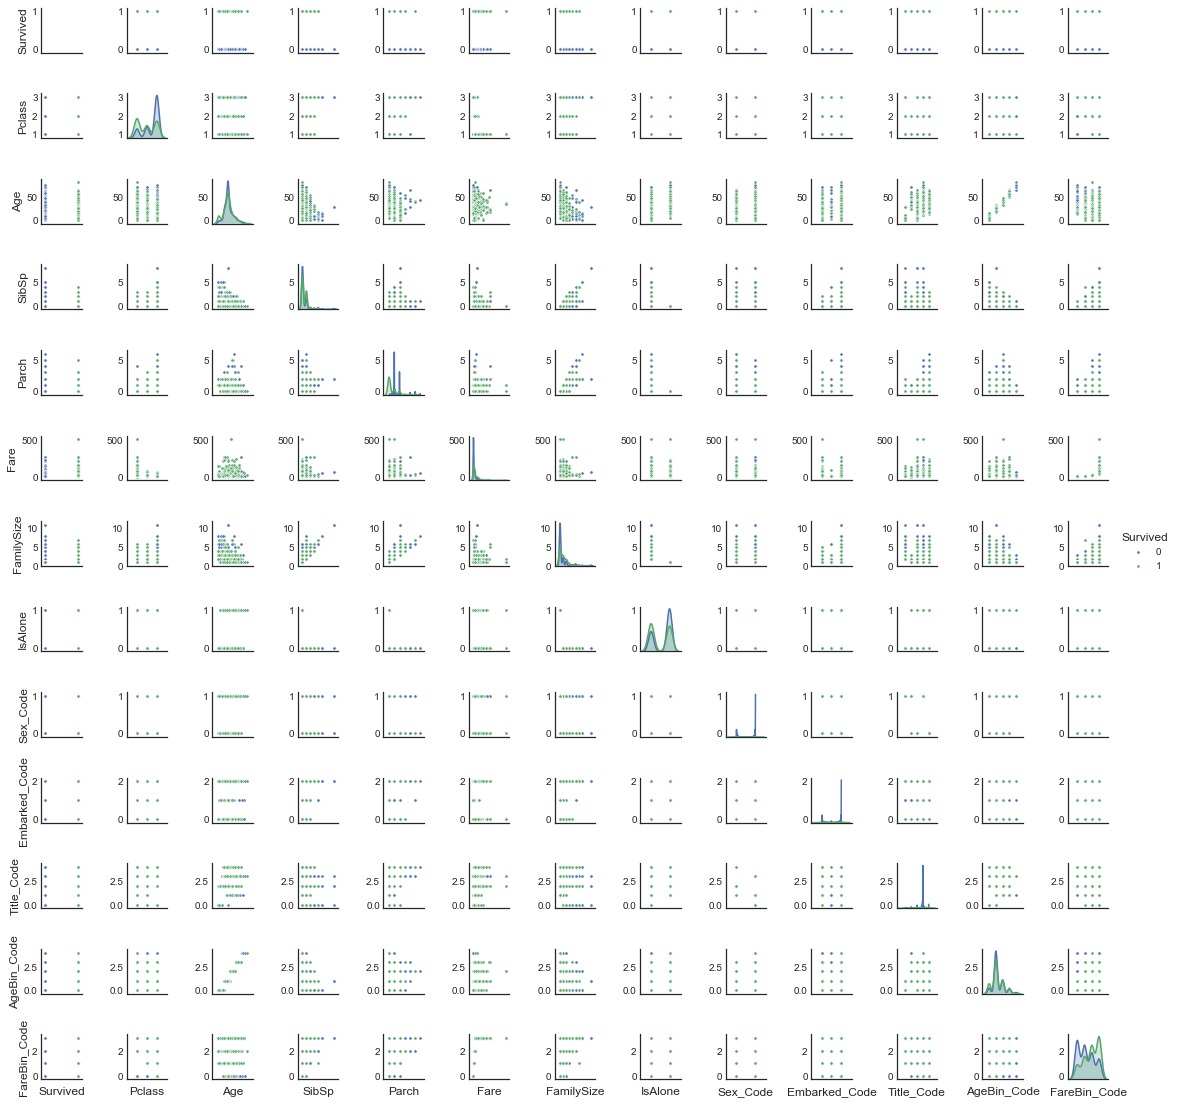

In [21]:
#pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

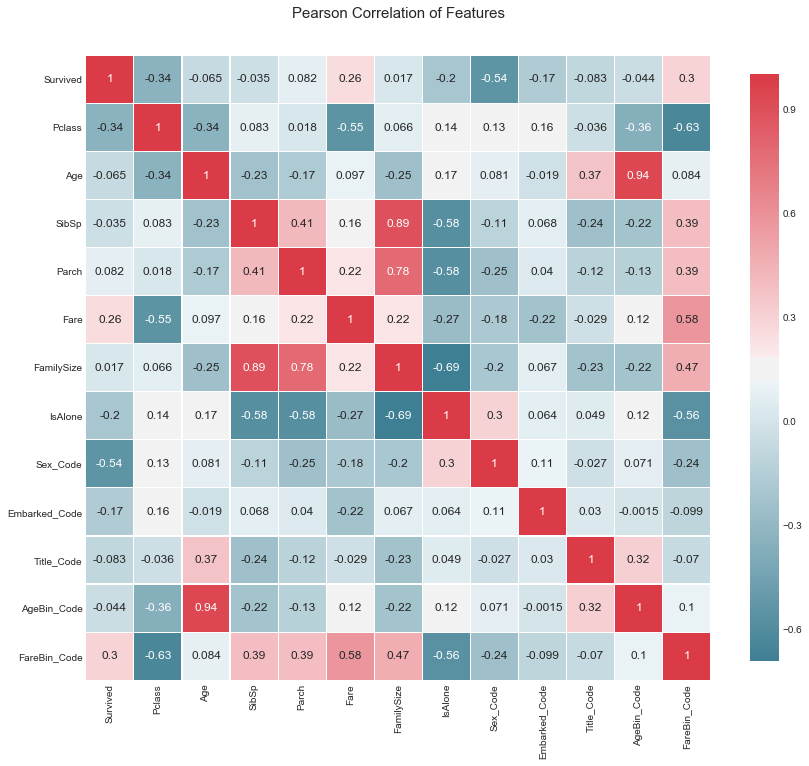

In [22]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)


Step 5: Model Data

In [23]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: #sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: #sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.0325878
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0319048
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891011,0.822761,0.0539757,0.0138892
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0355767
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.0602832
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.821642,0.05769,0.0130573
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.820896,0.0490498,0.00180218
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891386,0.820522,0.0491646,0.016618
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.818657,0.0711856,0.00163913
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00222776


Text(0,0.5,'Algorithm')

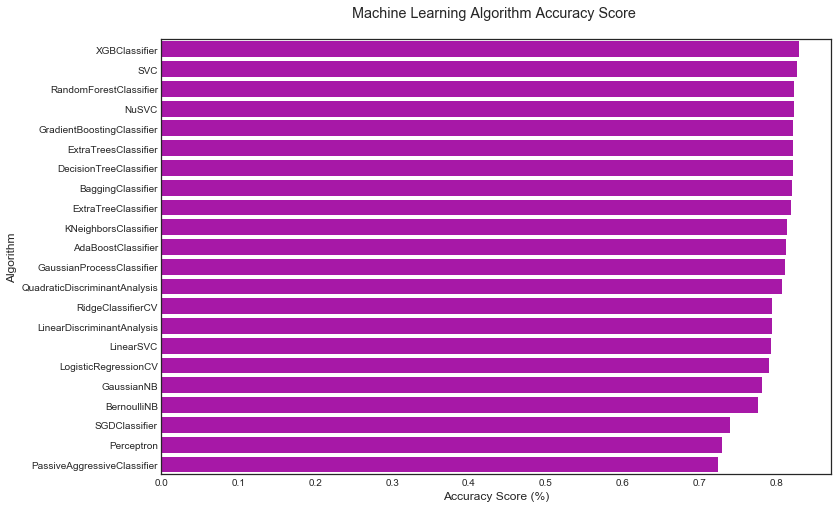

In [24]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [25]:
#IMPORTANT: This is a handmade model for learning purposes only.
#However, it is possible to create your own predictive model without a fancy algorithm :)

#coin flip model with random 1/survived 0/died

#iterate over dataFrame rows as (index, Series) pairs
for index, row in data1.iterrows(): 
    #random number generator
    if random.random() > .5:     # Random float x, 0.0 <= x < 1.0    
        data1.set_value(index, 'Random_Predict', 1) #predict survived/1
    else: 
        data1.set_value(index, 'Random_Predict', 0) #predict died/0
    

#score random guess of survival. Use shortcut 1 = Right Guess and 0 = Wrong Guess
#the mean of the column will then equal the accuracy
data1['Random_Score'] = 0 #assume prediction wrong
data1.loc[(data1['Survived'] == data1['Random_Predict']), 'Random_Score'] = 1 #set to 1 for correct prediction
print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))

#we can also use scikit's accuracy_score function to save us a few lines of code
#sklearn.metrics.accuracy_score
print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'], data1['Random_Predict'])*100))

Coin Flip Model Accuracy: 50.84%
Coin Flip Model Accuracy w/SciKit: 50.84%


In [26]:
#group by or pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
pivot_female = data1[data1.Sex=='female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n',pivot_female)

pivot_male = data1[data1.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n',pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000


In [27]:
#handmade data model using brain power (and Microsoft Excel Pivot Tables for quick calculations)
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model


#model data
Tree_Predict = mytree(data1)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(data1['Survived'], Tree_Predict)*100))


#Accuracy Summary Report with http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
#Where recall score = (true positives)/(true positive + false negative) w/1 being best:http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
#And F1 score = weighted average of precision and recall w/1 being best: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
print(metrics.classification_report(data1['Survived'], Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04%

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.32  0.68]]


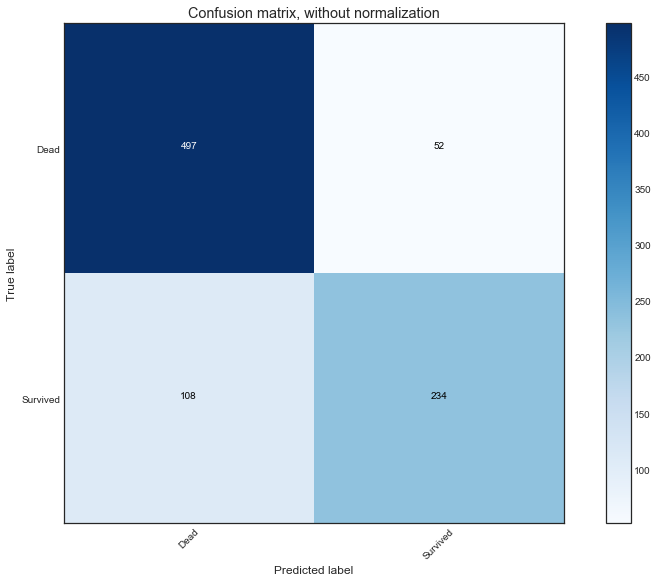

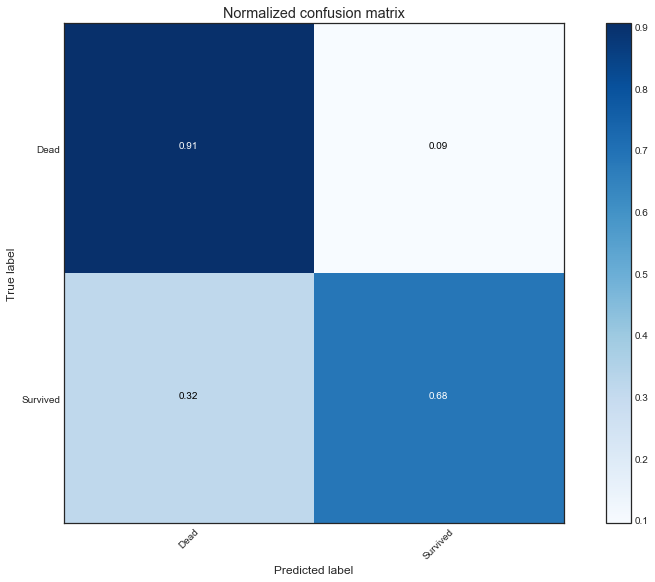

In [28]:
#Plot Accuracy Summary
#Credit
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [29]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


#duplicates gridsearchcv
#tune_results = model_selection.cross_validate(tune_model, data1[data1_x_bin], data1[Target], cv  = cv_split)

#print('AFTER DT Parameters: ', tune_model.best_params_)
#print("AFTER DT Training w/bin set score mean: {:.2f}". format(tune_results['train_score'].mean()*100)) 
#print("AFTER DT Test w/bin set score mean: {:.2f}". format(tune_results['test_score'].mean()*100))
#print("AFTER DT Test w/bin set score min: {:.2f}". format(tune_results['test_score'].min()*100))
#print('-'*10)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00
----------


In [30]:
#base model
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code' 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


In [38]:
#Graph MLA version of Decision Tree
import graphviz 
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = data1_x_bin, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

TypeError: export_graphviz() got an unexpected keyword argument 'size'

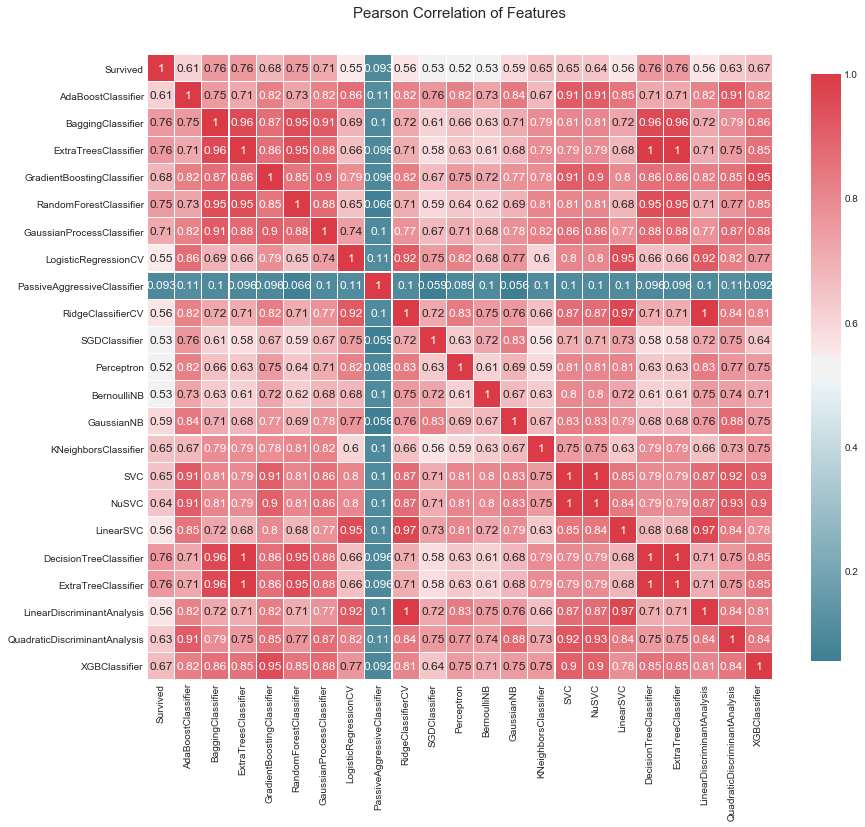

In [32]:
#compare algorithm predictions with each other, where 1 = exactly similar and 0 = exactly opposite
#there are some 1's, but enough blues and light reds to create a "super algorithm" by combining them
correlation_heatmap(MLA_predict)


In [33]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 86.59
Hard Voting Test w/bin score mean: 82.54
Hard Voting Test w/bin score 3*std: +/- 4.53
----------
Soft Voting Training w/bin score mean: 87.25
Soft Voting Test w/bin score mean: 82.46
Soft Voting Test w/bin score 3*std: +/- 3.85
----------


In [34]:
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 46.33 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 40.54 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 78.69 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 40.14 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 84.42 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 8.23 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_stat

In [35]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


#12/31/17 tuned with data1_x_bin
#The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 33.39 seconds.
#The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 30.28 seconds.
#The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 64.76 seconds.
#The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 34.35 seconds.
#The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 76.32 seconds.
#The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 6.01 seconds.
#The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 8.04 seconds.
#The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.19 seconds.
#The best parameter for GaussianNB is {} with a runtime of 0.04 seconds.
#The best parameter for KNeighborsClassifier is {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'} with a runtime of 4.84 seconds.
#The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 29.39 seconds.
#The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 46.23 seconds.
#Total optimization time was 5.56 minutes.

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 85.22
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.31
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.26
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 84.78
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.24
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.40
----------


In [37]:
#prepare data for modeling
print(data_val.info())
print("-"*10)
#data_val.sample(10)



#handmade decision tree - submission score = 0.77990
data_val['Survived'] = mytree(data_val).astype(int)


#decision tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_dt = tree.DecisionTreeClassifier()
#submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
#submit_dt.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
#data_val['Survived'] = submit_dt.predict(data_val[data1_x_bin])


#bagging w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77990
#submit_bc = ensemble.BaggingClassifier()
#submit_bc = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid= {'n_estimators':grid_n_estimator, 'max_samples': grid_ratio, 'oob_score': grid_bool, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_bc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_bc.best_params_) #Best Parameters:  {'max_samples': 0.25, 'n_estimators': 500, 'oob_score': True, 'random_state': 0}
#data_val['Survived'] = submit_bc.predict(data_val[data1_x_bin])


#extra tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_etc = ensemble.ExtraTreesClassifier()
#submit_etc = model_selection.GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_etc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_etc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_etc.predict(data_val[data1_x_bin])


#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205
#submit_rfc = ensemble.RandomForestClassifier()
#submit_rfc = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_rfc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_rfc.predict(data_val[data1_x_bin])



#ada boosting w/full dataset modeling submission score: defaults= 0.74162, tuned= 0.75119
#submit_abc = ensemble.AdaBoostClassifier()
#submit_abc = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators': grid_n_estimator, 'learning_rate': grid_ratio, 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_abc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_abc.best_params_) #Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}
#data_val['Survived'] = submit_abc.predict(data_val[data1_x_bin])


#gradient boosting w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77033
#submit_gbc = ensemble.GradientBoostingClassifier()
#submit_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid={'learning_rate': grid_ratio, 'n_estimators': grid_n_estimator, 'max_depth': grid_max_depth, 'random_state':grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_gbc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_gbc.best_params_) #Best Parameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
#data_val['Survived'] = submit_gbc.predict(data_val[data1_x_bin])

#extreme boosting w/full dataset modeling submission score: defaults= 0.73684, tuned= 0.77990
#submit_xgb = XGBClassifier()
#submit_xgb = model_selection.GridSearchCV(XGBClassifier(), param_grid= {'learning_rate': grid_learn, 'max_depth': [0,2,4,6,8,10], 'n_estimators': grid_n_estimator, 'seed': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_xgb.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_xgb.best_params_) #Best Parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0}
#data_val['Survived'] = submit_xgb.predict(data_val[data1_x_bin])


#hard voting classifier w/full dataset modeling submission score: defaults= 0.75598, tuned = 0.77990
#data_val['Survived'] = vote_hard.predict(data_val[data1_x_bin])
data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])


#soft voting classifier w/full dataset modeling submission score: defaults= 0.73684, tuned = 0.74162
#data_val['Survived'] = vote_soft.predict(data_val[data1_x_bin])
#data_val['Survived'] = grid_soft.predict(data_val[data1_x_bin])


#submit file
submit = data_val[['PassengerId','Survived']]
submit.to_csv("titanic_submit2のコピー.csv", index=False)

print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
FareBin          418 non-null category
AgeBin           418 non-null category
Sex_Code         418 non-null int64
Embarked_Code    418 non-null int64
Title_Code       418 non-null int64
AgeBin_Code      418 non-null int64
FareBin_Code     418 non-null int64
Survived         418 non-null int64
dtypes: category(2), float64(2), int64(12), object(6)
memory usage: 66.3+ KB
None
------

,PassengerId,Survived
202,1094,1
4,896,1
368,1260,1
165,1057,1
148,1040,0
109,1001,0
366,1258,0
264,1156,0
293,1185,0
15,907,1
